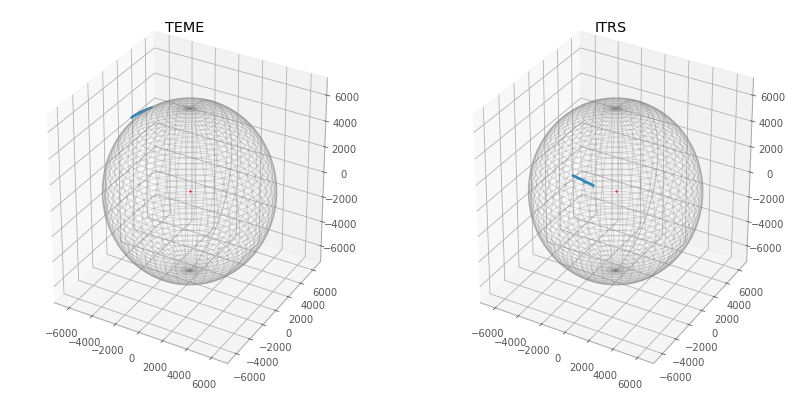

In [9]:
import time
import numpy as np

# Astropy 4.1rc1 is used
from astropy import units as u
from astropy.coordinates import EarthLocation, ITRS, ICRS, TEME, CartesianDifferential, CartesianRepresentation
from astropy.visualization import astropy_mpl_style
from astropy.time import Time

from scipy.integrate import odeint

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sgp4.api import Satrec, SGP4_ERRORS

from orbdet.utils.utils import *
from orbdet.utils.utils_vis import plot_sphere
from orbdet.utils.constants import *

np.set_printoptions(precision=6)
plt.style.use(astropy_mpl_style)
%matplotlib inline

f_downlink_falconsat = 435.103
tle_falconsat = [ '1 30776U 07006E   20146.24591950  .00002116  00000-0  57170-4 0  9998',
'2 30776  35.4350  68.4822 0003223 313.1473  46.8985 15.37715972733265']
epoch_start = Time('2020-05-27 23:46:00')
epoch_end = Time('2020-05-27 23:50:00')

#chilbolton = EarthLocation(lat=51.1483578*u.deg, lon=-1.4384458*u.deg, height=0.081*u.km)
site = EarthLocation(lat=33.7743331*u.deg, lon=-84.3970209*u.deg, height= 0.288*u.km)
site_itrs = site.get_itrs(obstime=epoch_start)

# Get satellite trajectory
e, r, v, jd, fr = get_satellite_sgp4(tle_falconsat, epoch_start, epoch_end, 1.0/86400.0)
t = Time(jd + fr, format='jd')

tt_datetime = t.to_datetime()
tt_sec = t.to_value('unix')
tt_sec -= tt_sec[0]

nt = len(fr)

r_teme = CartesianRepresentation(r[:,0], r[:,1], r[:,2], unit=u.km)
v_teme = CartesianDifferential(v[:,0], v[:,1], v[:,2], unit=u.km/u.s)
teme = TEME(r_teme.with_differentials(v_teme), obstime=t)

itrs = teme.transform_to(ITRS(obstime=t))

obs_temp = np.expand_dims(np.append(site_itrs.data.xyz.value, np.array([0,0,0])), axis=1)
obs_temp = np.repeat(obs_temp, nt, axis=1)
sat_temp = np.array([itrs.x.value, itrs.y.value, itrs.z.value, itrs.v_x.value, itrs.v_y.value, itrs.v_z.value])

# Plotting
fig = plt.figure(figsize=(14,7))

ax1 = fig.add_subplot(121, projection='3d')
ax1.set_title('TEME')
ax1.scatter(0, 0, 0, s=1, c='r', marker='x')
ax1.scatter(teme.x, teme.y, teme.z, s=1)
plot_sphere(ax1, R_EQ/1e3, 100)

ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title('ITRS')
ax2.scatter(0, 0, 0, s=1, c='r', marker='x')
ax2.scatter(itrs.x, itrs.y, itrs.z, s=1)
ax2.scatter(site_itrs.x, site_itrs.y, site_itrs.z, marker='o',c='green', s=1)
ax2.grid(':')
plot_sphere(ax2, R_EQ/1e3, 100)


(240,)


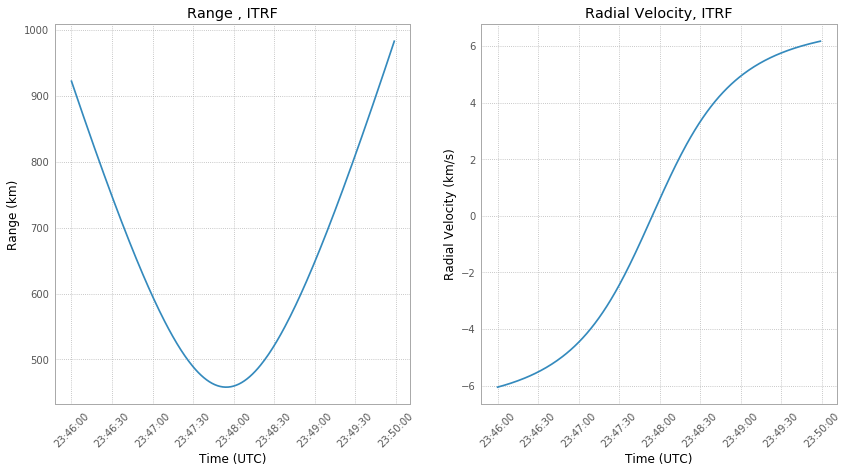

In [10]:
r, rr = range_range_rate(sat_temp, obs_temp)
print(rr.shape)

fig = plt.figure(figsize=(14,7))

ax1 = fig.add_subplot(121)
ax1.set_title('Range , ITRF')
ax1.set_xlabel('Time (UTC)')
ax1.set_ylabel('Range (km)')
ax1.plot(tt_datetime, r)
ax1.tick_params(axis='x', labelrotation=45)
ax1.grid(linestyle= ':')

ax2 = fig.add_subplot(122)
ax2.set_title('Radial Velocity, ITRF')
ax2.set_xlabel('Time (UTC)')
ax2.set_ylabel('Radial Velocity (km/s)')
ax2.plot(tt_datetime, rr)
ax2.tick_params(axis='x', labelrotation=45)
ax2.grid(linestyle=':')


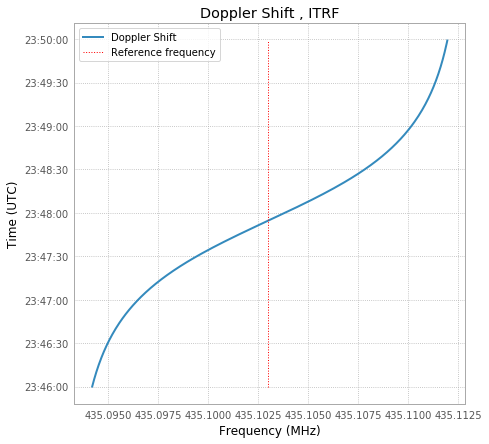

In [11]:
df = doppler_shift(sat_temp, obs_temp, f_downlink_falconsat, c=C/1e3)
f_temp = np.ones(len(df)) * f_downlink_falconsat

fig = plt.figure(figsize=(7,7))

ax1 = fig.add_subplot(111)
ax1.set_title('Doppler Shift , ITRF')
ax1.set_ylabel('Time (UTC)')
ax1.set_xlabel('Frequency (MHz)')
ax1.plot(df+f_temp, tt_datetime, linewidth=2.0, label="Doppler Shift")
ax1.plot(f_temp, tt_datetime, 'r:', linewidth=1.0, label="Reference frequency")
ax1.grid(linestyle= ':')
ax1.legend()

print()


x_orbdyn, (6, 240)
398600441800000.0
[  0.         0.999995   1.999989   2.999984   3.999978   4.999973
   6.000008   7.000002   7.999997   8.999991   9.999986  10.999981
  11.999975  13.00001   14.000005  14.999999  15.999994  16.999988
  17.999983  18.999977  19.999972  21.000007  22.000001  22.999996
  23.999991  24.999985  25.99998   26.999974  28.000009  29.000004
  29.999998  30.999993  31.999987  32.999982  33.999977  34.999971
  36.000006  37.        37.999995  38.99999   39.999984  40.999979
  41.999974  43.000008  44.000003  44.999997  45.999992  46.999986
  47.999981  48.999976  49.99997   51.000005  52.        52.999994
  53.999989  54.999983  55.999978  56.999973  58.000007  59.000002
  59.999996  60.999991  61.999986  62.99998   63.999975  65.00001
  66.000004  66.999999  67.999993  68.999988  69.999983  70.999977
  71.999972  73.000006  74.000001  74.999995  75.99999   76.999985
  77.999979  78.999974  80.000009  81.000003  81.999998  82.999992
  83.999987  84.999982  85

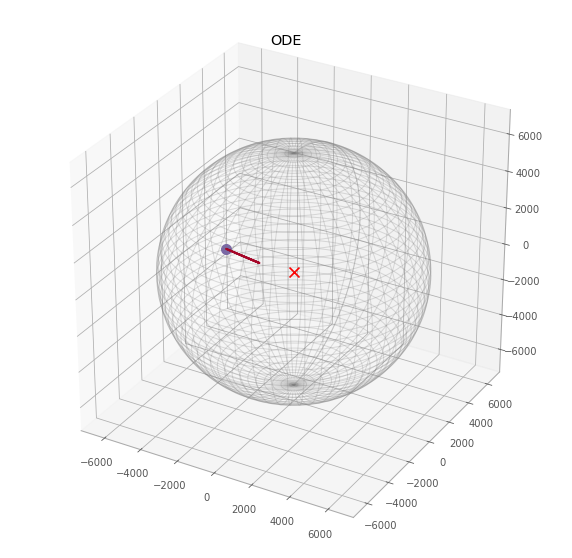

In [13]:
x_orbdyn = np.transpose(odeint(orbdyn_2body, sat_temp[:,0]*1e3, tt_sec, args=(MU,)))
print(f"x_orbdyn, {x_orbdyn.shape}")

fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(111, projection='3d')
ax1.set_title('ODE')
ax1.scatter(0, 0, 0, s=100, c='r', marker='x')
ax1.scatter(itrs.x[0], itrs.y[0], itrs.z[0], s=1)
ax1.scatter(sat_temp[0,0], sat_temp[1,0], sat_temp[2,0], 'rx', s=100)
ax1.scatter(x_orbdyn[0,:]/1e3, x_orbdyn[1,:]/1e3, x_orbdyn[2,:]/1e3, s=1)
plot_sphere(ax1, R_EQ/1e3, 100)

print(itrs.x[0], itrs.y[0], itrs.z[0])
print(sat_temp[0,0],sat_temp[1,0], sat_temp[2,0])
print(x_orbdyn.shape)



In [8]:
x_test = x_orbdyn[:,0:]
print(x_test.shape)
A = get_matrix_A(x_test)

print(A.shape)


(6, 10)
(6, 6, 10)
